# CNN Exploration

In [171]:
# Imports
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import utils
from keras.utils import to_categorical

In [3]:
# Reading in the data
mel_specs = pd.read_csv('../data/genre_mel_specs_clean.csv')

In [95]:
# First 5 rows for reference
mel_specs.head()

0          1          2          3          4          5  \
0 -24.185581 -27.340237 -27.214727 -23.694857 -10.349419 -11.817766   
1 -34.482864 -29.062458 -34.239838 -41.848854 -38.884560 -46.740932   
2 -31.571878 -38.357210 -37.502674 -32.508842 -22.891088 -28.224280   
3 -38.706380 -58.008110 -51.764940 -48.831757 -54.745650 -56.272590   
4 -13.395082 -22.886148 -39.371693 -39.873516 -44.111927 -41.430832   

           6          7          8          9  ...  84472  84473  84474  \
0 -19.678226 -26.396507 -25.827953 -30.779963  ...    0.0    0.0    0.0   
1 -41.780075 -42.449265 -37.310295 -38.989906  ...    0.0    0.0    0.0   
2 -33.885254 -35.000267 -35.614574 -36.325577  ...    0.0    0.0    0.0   
3 -52.029984 -54.152860 -57.492695 -55.962650  ...    0.0    0.0    0.0   
4 -35.432774 -43.907005 -44.259710 -45.559254  ...    0.0    0.0    0.0   

   84475  84476  84477  84478  84479  labels  y  
0    0.0    0.0    0.0    0.0    0.0  reggae  9  
1    0.0    0.0    0.0    0.0    0.0    jazz  6  
2    0.0    0.0    0.0    0.0    0.0   disco  4  
3    0.0    0.0    0.0    0.0    0.0    jazz  6  
4    0.0    0.0    0.0    0.0    0.0   disco  4  

[5 rows x 84482 columns]

## Data Preprocessing

### Function to Get a Subset of the Genres

In [130]:
def get_genre_subset(data, genre_subset):
    
    # Getting the subset of the genres and resetting the index
    df = data.loc[data['labels'].isin(genre_subset)]
    df = df.reset_index().drop(columns=['index'])
    
    # Creating a new label dictionary
    new_label_dict = {}
    for i in range(len(genre_subset)):
        new_label_dict[genre_subset[i]] = i
    
    # Changing labels
    df['y'] = df['labels'].map(new_label_dict)

    return df

### Function to Preprocess the Features and Targets

In [229]:
def preprocess_mel_spec_data(data, genre_subset):
    
    # Getting a subset of the genres using our genre_subset function
    subset = get_genre_subset(data, genre_subset)
    
    # Dropping label columns to prepare our feature vector
    specs = subset.drop(columns=['labels', 'y'])
    
    # Reshaping the arrays to their original "image" form
    X = []
    for i in range(len(genre_subset)*100):
        X.append(np.array(specs.iloc[i]).reshape(128,660))
        
    # Converting list X to an array
    X = np.array(X)
    
    # Defining our targets
    y = subset.loc[subset['labels'].isin(genre_subset), 'y'].values
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
    
    # Scaling our data to be between 0 and 1
    X_train /= -80
    X_test /= -80
    
    # Reshaping images to be 128 x 660 x 1
    X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
    X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)
    
    # One hot encoding our labels
    y_train = to_categorical(y_train, len(genre_subset))
    y_test = to_categorical(y_test, len(genre_subset))
    
    return X_train, X_test, y_train, y_test

In [132]:
# List of all the genres
genre_list = [ 
    'jazz',
    'reggae',
    'rock',
    'blues',
    'hiphop',
    'country',
    'metal',
    'classical',
    'disco',
    'pop'
]

In [199]:
# List of a subset of the genres
genre_subset = [
    'jazz',
    'reggae',
    'rock',
    'hiphop',
    'country',
    'metal',
    'classical'
]

In [200]:
# Using our function to get our features and targets
X_train, X_test, y_train, y_test = preprocess_mel_spec_data(mel_specs, genre_subset)

## CNN

In [205]:
# Initiating an empty neural network
cnn_model = Sequential(name='cnn_1')

# Adding convolutional layer
cnn_model.add(Conv2D(filters=8,
                     kernel_size=(3,3),
                     padding='same',
                     activation='relu',
                     input_shape=(128,660,1)))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(3,3)))

# Adding convolutional layer
cnn_model.add(Conv2D(16,
                     kernel_size=(3,3),
                     padding='same',
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten())
              
# Adding a dense layer with 128 neurons
cnn_model.add(Dense(128, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.5))

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.5))

# Adding an output layer
cnn_model.add(Dense(7, activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=20)

Train on 525 samples, validate on 175 samples
Epoch 1/20
525/525 [==============================] - 6s 11ms/sample - loss: 2.2357 - accuracy: 0.1505 - val_loss: 1.9084 - val_accuracy: 0.1657
Epoch 2/20
525/525 [==============================] - 5s 10ms/sample - loss: 1.8546 - accuracy: 0.2476 - val_loss: 1.7701 - val_accuracy: 0.2514
Epoch 3/20
525/525 [==============================] - 5s 10ms/sample - loss: 1.6143 - accuracy: 0.3695 - val_loss: 1.4777 - val_accuracy: 0.5143
Epoch 4/20
525/525 [==============================] - 5s 10ms/sample - loss: 1.4983 - accuracy: 0.4286 - val_loss: 1.3908 - val_accuracy: 0.5314
Epoch 5/20
525/525 [==============================] - 5s 10ms/sample - loss: 1.3590 - accuracy: 0.4648 - val_loss: 1.2761 - val_accuracy: 0.5771
Epoch 6/20
525/525 [==============================] - 5s 10ms/sample - loss: 1.2001 - accuracy: 0.5257 - val_loss: 1.2728 - val_accuracy: 0.5086
Epoch 7/20
525/525 [==============================] - 6s 11ms/sample - loss: 1.0899 

In [206]:
# Checking the model summary
cnn_model.summary()

Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 660, 8)       80        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 42, 220, 8)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 42, 220, 16)       1168      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 21, 110, 16)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 36960)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               4731008   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0     

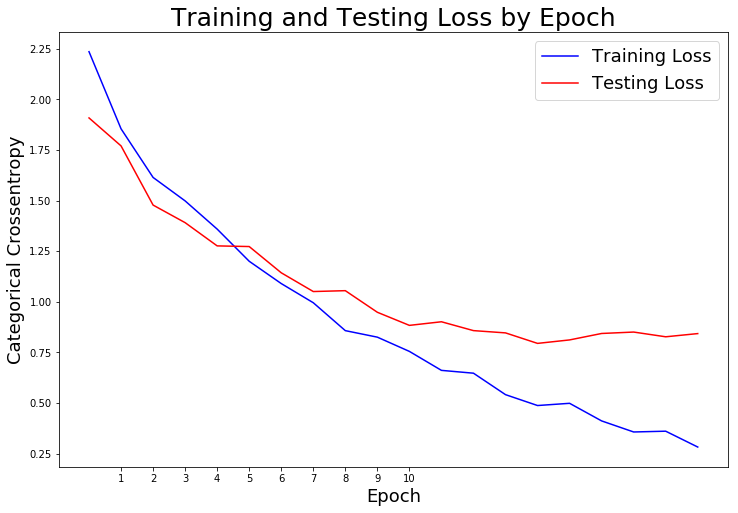

In [207]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,11), range(1,11))

plt.legend(fontsize = 18);

In [208]:
# Making predictions from the cnn model
predictions = cnn_model.predict(X_test, verbose=1)

175/175 [==============================] - 1s 3ms/sample


In [216]:
# Calculating the confusion matrix 
# row: actual
# columns: predicted
conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
conf_matrix

array([[16,  0,  1,  4,  1,  0,  3],
       [ 3, 10,  3,  7,  1,  0,  1],
       [ 0,  4, 16,  1,  1,  2,  1],
       [ 0,  1,  1, 22,  0,  1,  0],
       [ 4,  1,  8,  0, 10,  0,  2],
       [ 0,  0,  1,  1,  0, 23,  0],
       [ 1,  0,  0,  0,  0,  0, 24]])

In [217]:
# Creating a dataframe of the confusion matrix with labels for readability 
confusion_df = pd.DataFrame(conf_matrix)
confusion_df

0   1   2   3   4   5   6
0  16   0   1   4   1   0   3
1   3  10   3   7   1   0   1
2   0   4  16   1   1   2   1
3   0   1   1  22   0   1   0
4   4   1   8   0  10   0   2
5   0   0   1   1   0  23   0
6   1   0   0   0   0   0  24

In [218]:
# List of a subset of the genres
genre_labels = {
    0:'jazz',
    1:'reggae',
    2:'rock',
    3:'hiphop',
    4:'country',
    5:'metal',
    6:'classical'
}

In [219]:
# Renaming rows and columns with labes
confusion_df = confusion_df.rename(columns=genre_labels)
confusion_df.index = confusion_df.columns
confusion_df

jazz  reggae  rock  hiphop  country  metal  classical
jazz         16       0     1       4        1      0          3
reggae        3      10     3       7        1      0          1
rock          0       4    16       1        1      2          1
hiphop        0       1     1      22        0      1          0
country       4       1     8       0       10      0          2
metal         0       0     1       1        0     23          0
classical     1       0     0       0        0      0         24

## CNN 2

In [273]:
# List of a subset of the genres
genre_subset_2 = [
    'jazz',
    'reggae',
    'hiphop',
    'metal',
    'classical'
]

In [270]:
# Using our function to get our features and targets
X_train, X_test, y_train, y_test = preprocess_mel_spec_data(mel_specs, genre_subset_2)

In [275]:
# Initiating an empty neural network
cnn_model_2 = Sequential(name='cnn_2')

# Adding convolutional layer
cnn_model_2.add(Conv2D(filters=8,
                     kernel_size=(6,6),
                     padding='same',
                     activation='relu',
                     input_shape=(128,660,1)))

# Adding max pooling layer
cnn_model_2.add(MaxPooling2D(pool_size=(20,20)))

# Adding convolutional layer
cnn_model_2.add(Conv2D(16,
                     kernel_size=(6,6),
                     padding='same',
                     activation='relu'))

# Adding max pooling layer
cnn_model_2.add(MaxPooling2D(pool_size=(2,2)))

# Adding a flattened layer to input our image data
cnn_model_2.add(Flatten())
              
# Adding a dense layer with 256 neurons
cnn_model_2.add(Dense(256, activation='relu'))

# Adding a dropout layer for regularization
cnn_model_2.add(Dropout(0.5))

# Adding a dense layer with 64 neurons
cnn_model_2.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model_2.add(Dropout(0.5))

# Adding an output layer
cnn_model_2.add(Dense(5, activation='softmax'))

# Compiling our neural network
cnn_model_2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
history = cnn_model_2.fit(X_train,
                          y_train, 
                          batch_size=16,
                          validation_data=(X_test, y_test),
                          epochs=20)

Train on 375 samples, validate on 125 samples
Epoch 1/15
375/375 [==============================] - 6s 17ms/sample - loss: 1.6159 - accuracy: 0.1707 - val_loss: 1.5973 - val_accuracy: 0.1920
Epoch 2/15
375/375 [==============================] - 6s 15ms/sample - loss: 1.5868 - accuracy: 0.1760 - val_loss: 1.5793 - val_accuracy: 0.3680
Epoch 3/15
375/375 [==============================] - 6s 16ms/sample - loss: 1.5398 - accuracy: 0.2693 - val_loss: 1.6118 - val_accuracy: 0.2000
Epoch 4/15
375/375 [==============================] - 6s 16ms/sample - loss: 1.5976 - accuracy: 0.2107 - val_loss: 1.5150 - val_accuracy: 0.3200
Epoch 5/15
375/375 [==============================] - 6s 17ms/sample - loss: 1.4873 - accuracy: 0.3520 - val_loss: 1.3978 - val_accuracy: 0.5280
Epoch 6/15
375/375 [==============================] - 6s 16ms/sample - loss: 1.3230 - accuracy: 0.4427 - val_loss: 1.1736 - val_accuracy: 0.5360
Epoch 7/15
375/375 [==============================] - 6s 16ms/sample - loss: 1.1594 

In [276]:
# Checking the model summary
cnn_model_2.summary()

Model: "cnn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 128, 660, 8)       296       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 6, 33, 8)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 6, 33, 16)         4624      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 3, 16, 16)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 768)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)               196864    
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0     

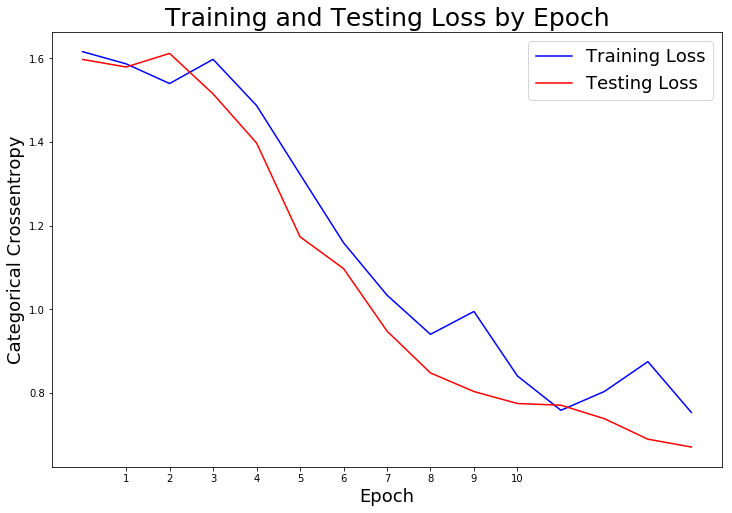

In [277]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,11), range(1,11))

plt.legend(fontsize = 18);

In [278]:
# Making predictions from the cnn model
predictions_2 = cnn_model_2.predict(X_test, verbose=1)

125/125 [==============================] - 0s 4ms/sample


In [279]:
# Calculating the confusion matrix 
# row: actual
# columns: predicted
conf_matrix_2 = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions_2, 1))
conf_matrix_2

array([[15,  1,  0,  0,  9],
       [ 2, 19,  2,  0,  2],
       [ 0, 10, 13,  2,  0],
       [ 2,  1,  3, 19,  0],
       [ 0,  0,  0,  0, 25]])

In [280]:
# Creating a dataframe of the confusion matrix with labels for readability 
confusion_df_2 = pd.DataFrame(conf_matrix_2)

In [281]:
# List of a subset of the genres
genre_labels_2 = {
    0:'jazz',
    1:'reggae',
    2:'rock',
    3:'hiphop',
    4:'metal',
    5:'classical'
}

In [282]:
# Renaming rows and columns with labes
confusion_df_2 = confusion_df_2.rename(columns=genre_labels_2)
confusion_df_2.index = confusion_df_2.columns
confusion_df_2

jazz  reggae  rock  hiphop  metal
jazz      15       1     0       0      9
reggae     2      19     2       0      2
rock       0      10    13       2      0
hiphop     2       1     3      19      0
metal      0       0     0       0     25